# Working with Time-Series Data

Time-series with date-time index:
- Deriving features
- Time-series prediction as supervised regression
  - Using random forest regressor
  - Using linear regression with l2 regularization (ridge regression)

Follow _Introduction to Machine Learning_ [Chapter 4](https://github.com/amueller/introduction_to_ml_with_python/blob/master/04-representing-data-feature-engineering.ipynb):
- Section 4.8 Utilizing Expert Knowledge



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import mglearn

## 1. Citi-bike dataset: Predicting bike share numbers
>In New York, Citi Bike operates a network of bicycle rental stations with a subscription system. The stations are all over the city and provide a convenient way to get around. Bike rental data is made public in an anonymized form and has been analyzed in various ways. The task we want to solve is to predict for a given time and day how many people will rent a bike in front of Andreas’s house—so he knows if any bikes will be left for him.

In [3]:
citibike = mglearn.datasets.load_citibike()

In [4]:
print("Citi Bike data:\n{}".format(citibike.head()))

Citi Bike data:
starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
Freq: 3H, Name: one, dtype: int64


### Plotting with matplotlib
pandas Series can be ploted directly

Text(0, 0.5, 'Rentals')

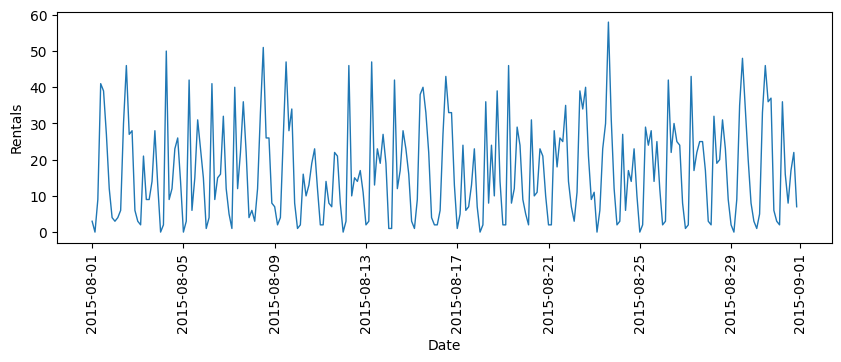

In [5]:
plt.figure(figsize=(10, 3))
# pandas Series can be ploted directly
plt.plot(citibike, linewidth=1)
# dates are more visible when rotated
for tick in plt.gca().get_xticklabels():
    tick.set_rotation(90)
plt.xlabel("Date")
plt.ylabel("Rentals")

Or we can plot the values and add custom ticks

Text(0, 0.5, 'Rentals')

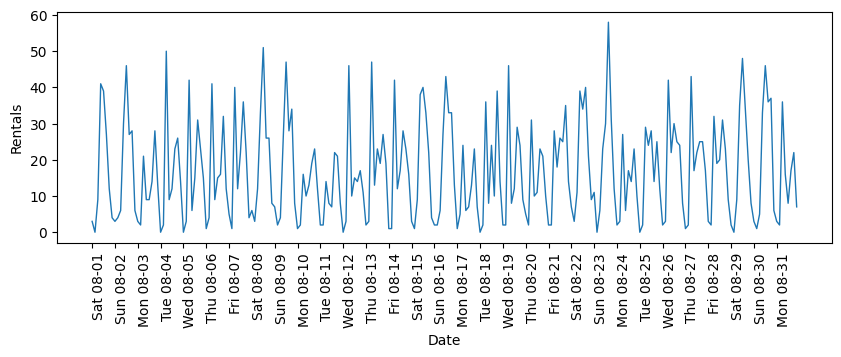

In [6]:
plt.figure(figsize=(10, 3))
xticks = pd.date_range(start=citibike.index.min(), end=citibike.index.max(),
                       freq='D')
# find the date locations in the original inded
xtick_loc = [citibike.index.get_loc(dt) for dt in xticks]
# format the dates
xtick_str = xticks.strftime("%a %m-%d")

plt.xticks(xtick_loc, xtick_str , rotation=90, ha="left")
# plot the values without datetime index
plt.plot(citibike.values, linewidth=1)
plt.xlabel("Date")
plt.ylabel("Rentals")

### Using Pandas to plot

<AxesSubplot: xlabel='starttime'>

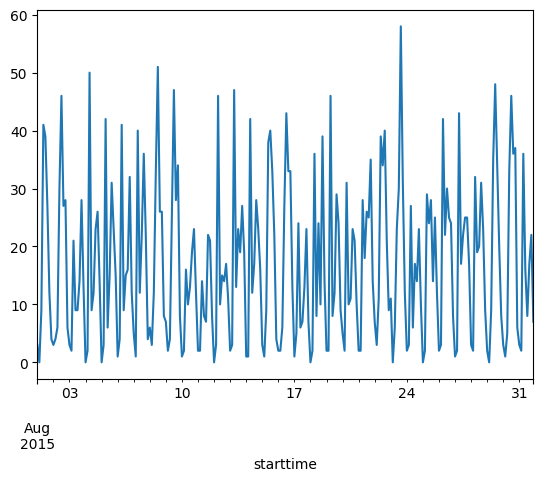

In [7]:
citibike.plot()

## 2. Predicting using a RandomForestRegressor
>The only feature that we are using in our prediction task is the date and time when a particular number of rentals occurred. So, the input feature is the date and time—say, 2015-08-01 00:00:00—and the output is the number of rentals in the following three hours (three in this case, according to our DataFrame).

>A (surprisingly) common way that dates are stored on computers is using POSIX time, which is the number of seconds since January 1970 00:00:00 (aka the beginning of Unix time). As a first try, we can use this single integer feature as our data representation:

In [8]:
# extract the target values (number of rentals)
y = citibike.values
# convert to POSIX time by dividing by 10**9
X = citibike.index.astype("int64").values.reshape(-1, 1) // 10**9

In [9]:
X.shape

(248, 1)

In [10]:
print(X[:5])

[[1438387200]
 [1438398000]
 [1438408800]
 [1438419600]
 [1438430400]]


### Import utility functions
Utility functions are now in a module so that all notebooks can use them

In [11]:
from timeseries_utils import create_xticks, eval_on_features

In [12]:
xticks = create_xticks(citibike.index)

Customizing the `eval_on_features` function with partial

In [13]:
from functools import partial
eval_on_features_1 = partial(eval_on_features, xticks=xticks)

### Using posix time as feature

Train-set r2: 0.85
Val-set r2: -0.04
Train-set neg_root_mean_squared_error: -5.21
Val-set neg_root_mean_squared_error: -13.43


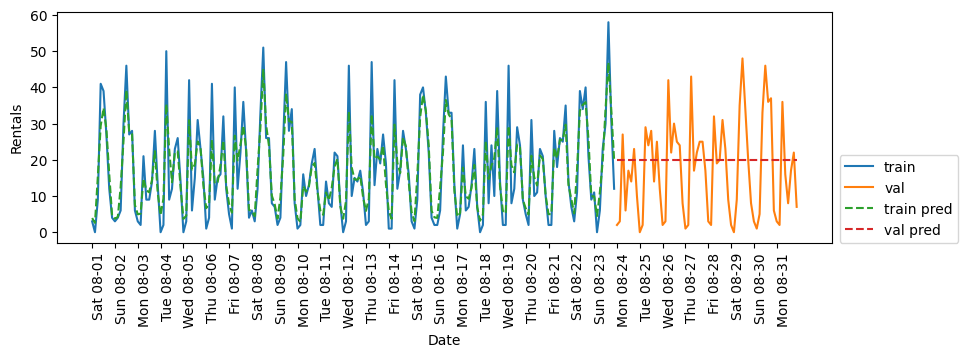

In [14]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=0)

eval_on_features_1(X, y, rf_regressor)

>The problem lies in the combination of our feature and the random forest. The value of the POSIX time feature for the test set is outside of the range of the feature values in the training set: the points in the test set have timestamps that are later than all the points in the training set. 

>Trees, and therefore random forests, cannot extrapolate to feature ranges outside the training set. 

### Using hour-of-day as feature
Pandas index is a `DatetimeIndex` object and individual elements of a date-time can be accessed as attributes.

In [15]:
type(citibike.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [16]:
citibike.index.hour.values[:10]

array([ 0,  3,  6,  9, 12, 15, 18, 21,  0,  3])

In [17]:
# need reshape to create 2D matrix
# We want 1 column and let reshape figure out the number of rows by passing -1
X_hour = citibike.index.hour.values.reshape(-1, 1) 
X_hour[:5,:] # first 5 rows

array([[ 0],
       [ 3],
       [ 6],
       [ 9],
       [12]])

Train-set r2: 0.50
Val-set r2: 0.60
Train-set neg_root_mean_squared_error: -9.64
Val-set neg_root_mean_squared_error: -8.35


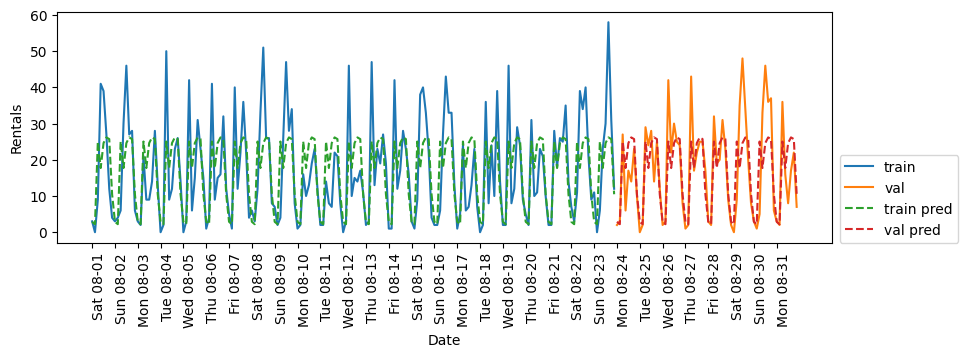

In [18]:
eval_on_features_1(X_hour, y, rf_regressor)

### Using day-of-week and hour-of-day as features

In [19]:
# creating columns first, then stacking these horizontaly
X_hour_week = np.hstack([citibike.index.dayofweek.values.reshape(-1, 1),
                         citibike.index.hour.values.reshape(-1, 1)])
X_hour_week[:5,:] # first 5 rows

array([[ 5,  0],
       [ 5,  3],
       [ 5,  6],
       [ 5,  9],
       [ 5, 12]])

Train-set r2: 0.89
Val-set r2: 0.84
Train-set neg_root_mean_squared_error: -4.51
Val-set neg_root_mean_squared_error: -5.25


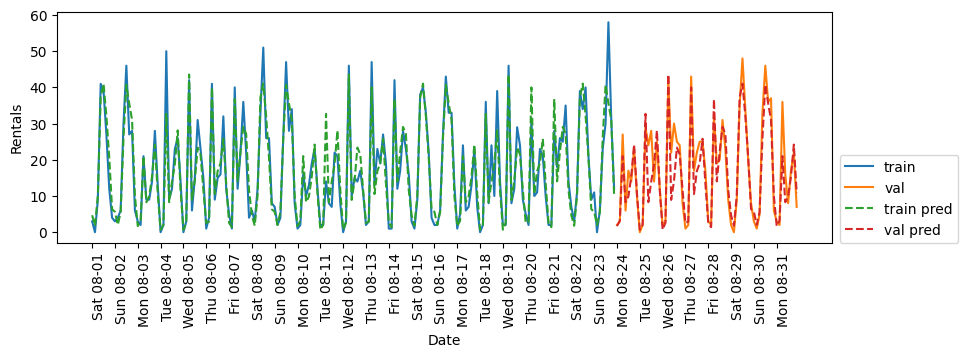

In [20]:
eval_on_features_1(X_hour_week, y, rf_regressor)

(-1.0, 2.0)

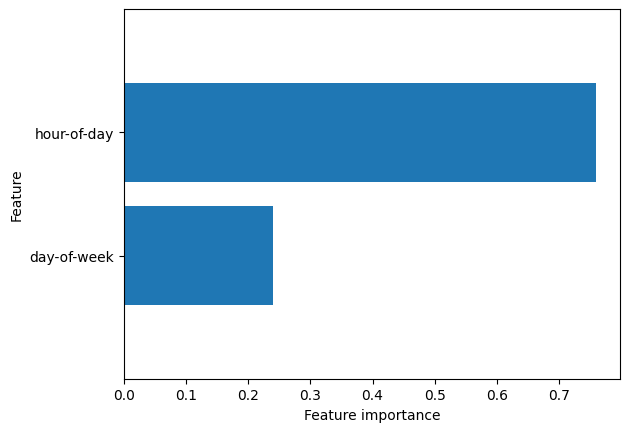

In [21]:
n_features = X_hour_week.shape[1] #n_features = n_columns
plt.barh(np.arange(n_features), rf_regressor.feature_importances_, align='center')
plt.yticks(np.arange(n_features), ['day-of-week','hour-of-day'])
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.ylim(-1, n_features)

## 3. Predicting using Ridge regression
### Using day-of-week and hour-of-day as features

Train-set r2: 0.16
Val-set r2: 0.13
Train-set neg_root_mean_squared_error: -12.44
Val-set neg_root_mean_squared_error: -12.30


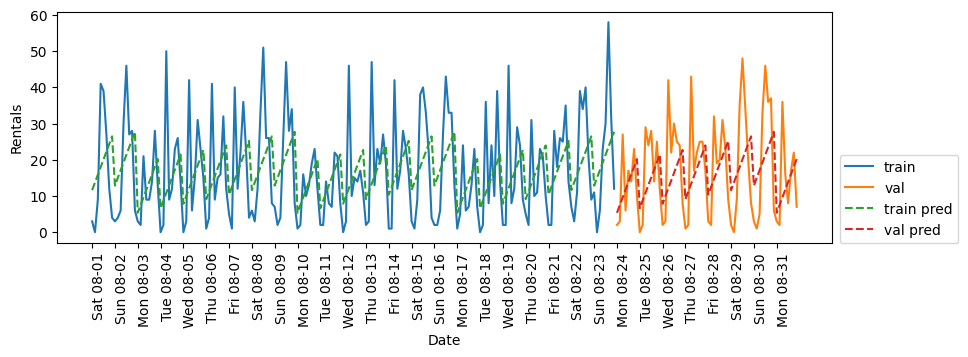

In [22]:
from sklearn.linear_model import Ridge
eval_on_features_1(X_hour_week, y, Ridge())

With only two features encoded using integers (akin to ordinal encoding), linear regression (with l2 regularization) is not able to find the patterns. Let's use one-hot-encoding to generate more features.

### OneHotEncoding day-of-week and hour-of-day as features

In [23]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
X_hour_week_onehot = enc.fit_transform(X_hour_week).toarray()

In [24]:
X_hour_week_onehot.shape

(248, 15)

Train-set r2: 0.53
Val-set r2: 0.62
Train-set neg_root_mean_squared_error: -9.28
Val-set neg_root_mean_squared_error: -8.15


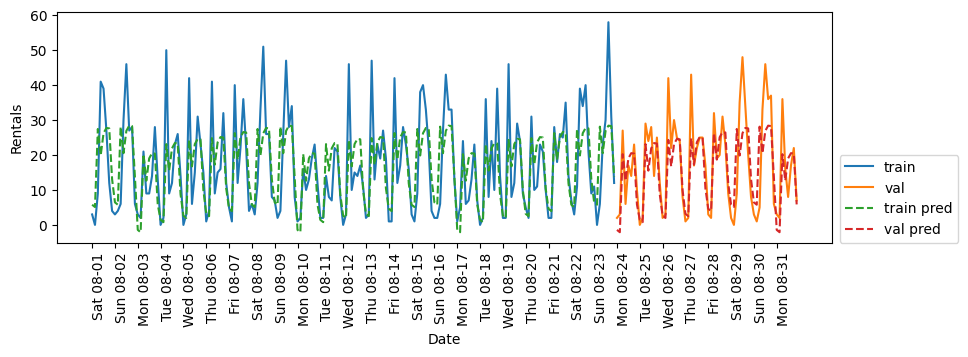

In [25]:
from sklearn.linear_model import Ridge
eval_on_features_1(X_hour_week_onehot, y, Ridge())

### Adding interactions between hour and day (using PolynomialFeatures())

Train-set r2: 0.87
Val-set r2: 0.85
Train-set neg_root_mean_squared_error: -4.84
Val-set neg_root_mean_squared_error: -5.19


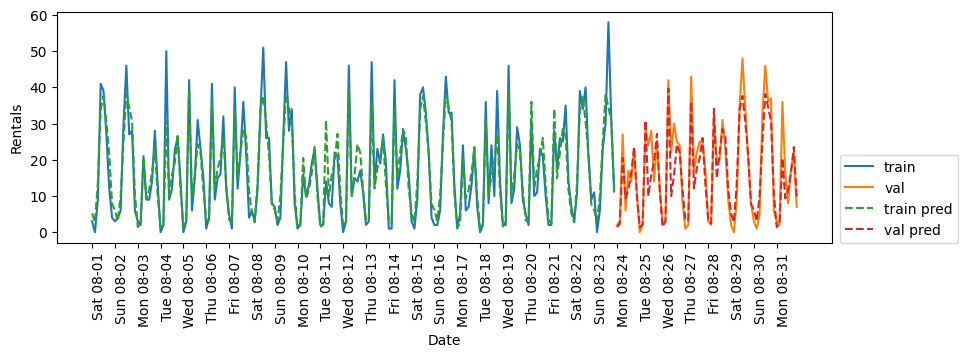

In [26]:
from sklearn.preprocessing import PolynomialFeatures
poly_transformer = PolynomialFeatures(degree=2, interaction_only=True,
                                      include_bias=False)
X_hour_week_onehot_poly = poly_transformer.fit_transform(X_hour_week_onehot)
lr = Ridge()
eval_on_features_1(X_hour_week_onehot_poly, y, lr)

In [27]:
X_hour_week_onehot_poly.shape

(248, 120)

### Plotting Ridge regression coefficients for poly-one-hot features

In [28]:
hour = ["%02d:00" % i for i in range(0, 24, 3)]
day = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
features =  day + hour

In [29]:
features_poly = poly_transformer.get_feature_names_out(features)
features_nonzero = np.array(features_poly)[lr.coef_ != 0]
coef_nonzero = lr.coef_[lr.coef_ != 0]

Text(0, 0.5, 'Feature magnitude')

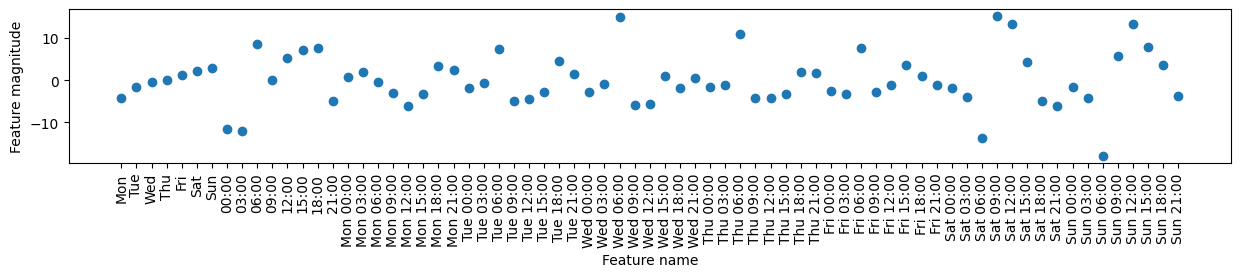

In [30]:
plt.figure(figsize=(15, 2))
plt.plot(coef_nonzero, 'o')
plt.xticks(np.arange(len(coef_nonzero)), features_nonzero, rotation=90)
plt.xlabel("Feature name")
plt.ylabel("Feature magnitude")

## 4. More insight into RandomForest

Although RandomForest is fine with ordinal features, we use the one-hot encoded features to investigate feature importances in greater detail.

Train-set r2: 0.89
Val-set r2: 0.84
Train-set neg_root_mean_squared_error: -4.52
Val-set neg_root_mean_squared_error: -5.27


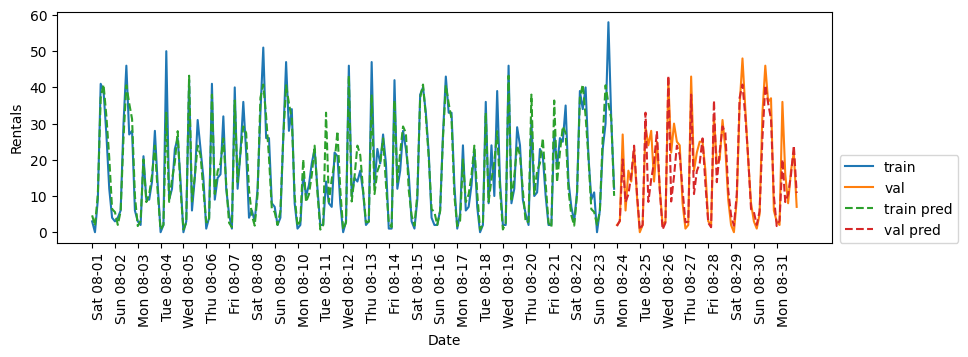

In [31]:
eval_on_features_1(X_hour_week_onehot, y, rf_regressor)

(-1.0, 15.0)

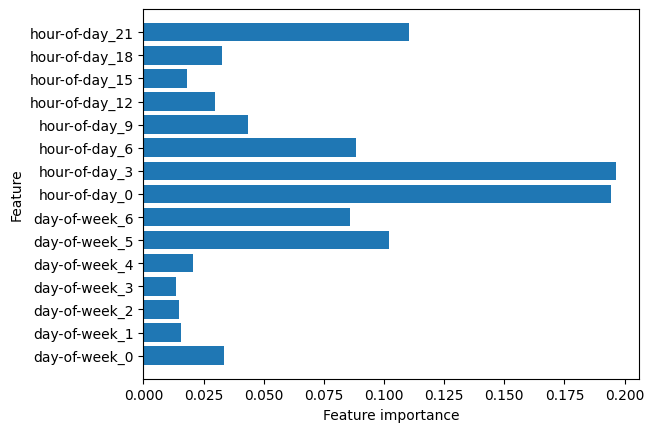

In [32]:
n_features = X_hour_week_onehot.shape[1]
plt.barh(np.arange(n_features), rf_regressor.feature_importances_, align='center')
plt.yticks(np.arange(n_features), enc.get_feature_names_out(['day-of-week','hour-of-day']))
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.ylim(-1, n_features)

Train-set r2: 0.89
Val-set r2: 0.84
Train-set neg_root_mean_squared_error: -4.53
Val-set neg_root_mean_squared_error: -5.32


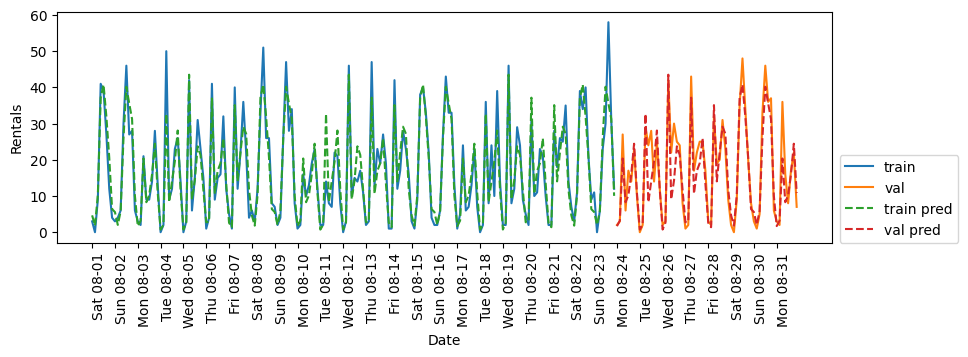

In [33]:
eval_on_features_1(X_hour_week_onehot_poly, y, rf_regressor)

In [34]:
features_poly = poly_transformer.get_feature_names_out(features)
features_nonzero = np.array(features_poly)[rf_regressor.feature_importances_ != 0]
coef_nonzero = rf_regressor.feature_importances_[rf_regressor.feature_importances_ != 0]

(-1.0, 71.0)

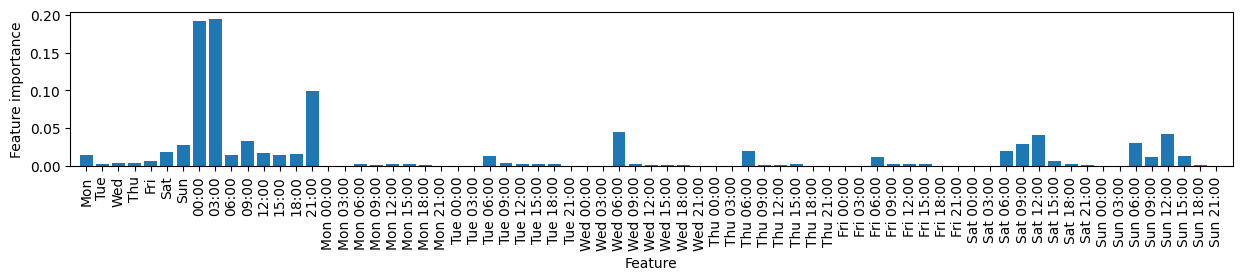

In [35]:
fig, ax = plt.subplots(figsize=(15, 2))
n_features = len(coef_nonzero)
plt.bar(np.arange(n_features), coef_nonzero, align='center')
plt.xticks(np.arange(n_features), features_nonzero, rotation=90)
plt.ylabel("Feature importance")
plt.xlabel("Feature")
plt.xlim(-1, n_features)

## Summary

feature | num of features | model | train r2 | valid r2| train rms | valid rms|
:-: | :-: |:-: |:-: |:-: |:-: |:-: |
Posix time | 1 | Random forest | 0.84 | -0.04 | 5.21 | 13.43 |
Hour-of-day | 1 | Random forest | 0.50 | 0.60 | 9.64 | 8.35 |
Hour-of-day, Day-of-week | 2 | Random forest | 0.89 | 0.84 | 4.51 | 5.25 |
Hour-of-day, Day-of-week | 2 | Ridge regression | 0.16 | 0.13 | 12.44 | 12.30 |
OneHot(Hour-of-day, Day-of-week) | 15 | Ridge regression | 0.53 | 0.62 | 9.28 | 8.15 |
Poly(OneHot(Hour-of-day, Day-of-week)) | 120 | Ridge regression | 0.87 | 0.85 | 4.84 | 5.19 |


If we have a time series with date-time index, we can derive useful features for time-series prediction.

There are many ready-made attributes of a date-time index:

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html